In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### データの用意

In [4]:
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_valid, y_valid) = mnist.load_data()

In [5]:
X_train.shape

(60000, 28, 28)

In [6]:
X_train.dtype

dtype('uint8')

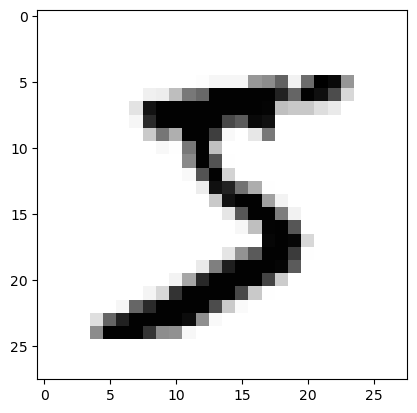

In [9]:
plt.imshow(X_train[0], "Greys")
plt.show()

In [10]:
# 平坦化
X_train = X_train.reshape(-1, 784)
X_valid = X_valid.reshape(-1, 784)

In [11]:
# 0-1化
X_train = X_train.astype(float) / 255
X_valid = X_valid.astype(float) / 255

In [12]:
# 分割
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(48000, 784)
(48000,)
(12000, 784)
(12000,)


In [13]:
# one-hot化
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_valid_one_hot = enc.transform(y_valid[:, np.newaxis])
print(X_train.shape)
print(y_train_one_hot.shape)
print(X_valid.shape)
print(y_valid_one_hot.shape)

(48000, 784)
(48000, 10)
(12000, 784)
(12000, 10)


### ミニバッチイテレータ

In [14]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size=20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0] / self.batch_size).astype(int)

    def __len__(self):
        return self._stop

    def __getitem__(self, item):
        p0 = item * self.batch_size
        p1 = item * self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter * self.batch_size
        p1 = self._counter * self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

### 実装

In [15]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer, activation):
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.optimizer = optimizer
        self.activation = activation
        # 初期化
        # initializerのメソッドを使い、self.W と self.b を初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.b = initializer.b(n_nodes2)

    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        self.X = X
        y = np.dot(X, self.W) + self.b
        return self.activation.forward(y)

    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        dA = self.activation.backward(dA)
        self.db = np.mean(dA, axis=0)
        self.dW = np.dot(self.X.T, dA) / len(self.X)
        dZ = np.dot(dA, self.W.T)
        # 更新
        self = self.optimizer.update(self)
        return dZ

In [16]:
class SGD:

    def __init__(self, lr):
        self.lr = lr

    def update(self, fc):
        fc.W -= self.lr * fc.dW
        fc.b -= self.lr * fc.db

In [17]:
class AdaGrad:

    def __init__(self, lr):
        self.lr = lr
        self.hW = 0
        self.hb = 0

    def update(self, fc):
        self.hW += fc.dW * fc.dW
        self.hb = fc.db * fc.db
        fc.W -= self.lr * fc.dW / (np.sqrt(self.hW) + 1e-8)
        fc.b -= self.lr * fc.db / (np.sqrt(self.hb) + 1e-8)

In [18]:
class Sigmoid:
        
    def forward(self, a):
        self.a = a
        self.Z = 1 / (1 + np.exp(-self.a))
        return self.Z

    def backward(self, dZ):
        return dZ * (1 - self.Z) * self.Z

In [19]:
class ReLU:

    def forward(self, a):
        self.a = a
        return np.maximum(self.a, 0)

    def backward(self, dZ):
        return np.where(self.a > 0, dZ, 0)

In [20]:
class Softmax:
        
    def forward(self, a):
        return np.exp(a - np.max(a)) / np.sum(np.exp(a - np.max(a)), axis=1, keepdims=True)
    
    def backward(self, dZ):
        return dZ

In [21]:
class SimpleInitializer:

    def __init__(self, sigma):
        self.sigma = sigma

    def W(self, n_nodes1, n_nodes2):
        return self.sigma * np.random.randn(n_nodes1, n_nodes2)

    def b(self, n_nodes2):
        return np.zeros(n_nodes2)

In [22]:
class XavierInitializer:

    def W(self, n_nodes1, n_nodes2):
        return np.random.randn(n_nodes1, n_nodes2) * np.sqrt(1 / n_nodes1)

    def b(self, n_nodes2):
        return np.zeros(n_nodes2)

In [23]:
class HeInitializer:

    def W(self, n_nodes1, n_nodes2):
        return np.random.randn(n_nodes1, n_nodes2) * np.sqrt(2 / n_nodes1)

    def b(self, n_nodes2):
        return np.zeros(n_nodes2)

### メインクラスの実装

In [24]:
# ニューラルネットワークスクラッチ
class ScratchDeepNeuralNetrowkClassifier:

    def __init__(self, layers, verbose=False):
        self.layers = layers
        self.verbose = verbose

    # 交差エントロピー誤差
    def _loss_function(self, y, yt):
        eps = 1e-8
        return -np.mean(yt * np.log(y + eps))

    def fit(self, X, y, X_val=None, y_val=None, n_epoch=50, n_batch=20, lr=0.01):
        # 各エポックの loss を記録するリスト
        self.log_loss = []
        self.log_loss_val = []
        # エポックごとの指標値を評価する: 精度
        self.log_acc = []
        self.log_acc_val = []
        
        for epoch in range(n_epoch):
            # ミニバッチ処理
            get_mini_batch = GetMiniBatch(X, y, batch_size=n_batch)
            
            self.loss = 0
            self.true_y = np.array([])
            self.pred_y = np.array([])
            
            for mini_X_train, mini_y_train in get_mini_batch:
                # forward
                x = mini_X_train
                for l in self.layers:
                    x = l.forward(x)
                z = x
                # backward
                b = (z - mini_y_train) / n_batch
                for l in reversed(self.layers):
                    b = l.backward(b)
                # 結果を保存
                self.true_y = np.concatenate([self.true_y, np.argmax(mini_y_train, axis=1)])
                self.pred_y = np.concatenate([self.pred_y, np.argmax(z, axis=1)])
                # 損失関数
                self.loss += self._loss_function(z, mini_y_train)

            # 各エポックの損失関数を記録する
            self.log_loss.append(self.loss / len(get_mini_batch))
            # 精度
            acc = accuracy_score(self.true_y, self.pred_y)
            self.log_acc.append(acc)

            # 検証データが入力されたら計算する
            if X_val is not None:
                # forward
                x = X_val
                for l in self.layers:
                    x = l.forward(x)
                z = x
                y_hat = np.argmax(x, axis=1)
                # 損失関数
                self.loss_val = self._loss_function(z, y_val)
                self.log_loss_val.append(self.loss_val)
                # 精度
                acc_val = accuracy_score(np.argmax(y_val, axis=1), y_hat)
                self.log_acc_val.append(acc_val)

            # verbose を true に設定すると、学習過程などを出力する
            if self.verbose:
                print(f"epoch:{epoch:>3} loss:{(self.loss / n_batch):>8,.3f} acc:{acc:>5,.3f}")

    def predict(self, X):
        # forward
        x = X
        for l in self.layers:
            x = l.forward(x)
        return np.argmax(x, axis=1)

### ネットワークパターン１

In [25]:
nn = [
    FC(784, 400, HeInitializer(), AdaGrad(0.01), ReLU()),
    FC(400, 200, HeInitializer(), AdaGrad(0.01), ReLU()),
    FC(200, 10, SimpleInitializer(0.01), AdaGrad(0.01), Softmax()),
]

In [26]:
clf = ScratchDeepNeuralNetrowkClassifier(layers=nn, verbose=True)
clf.fit(X_train, y_train_one_hot, X_valid, y_valid_one_hot, n_epoch=10, n_batch=20, lr=0.01)

epoch:  0 loss:   2.550 acc:0.934
epoch:  1 loss:   1.283 acc:0.968
epoch:  2 loss:   1.021 acc:0.975
epoch:  3 loss:   0.873 acc:0.978
epoch:  4 loss:   0.750 acc:0.981
epoch:  5 loss:   0.650 acc:0.984
epoch:  6 loss:   0.583 acc:0.986
epoch:  7 loss:   0.530 acc:0.988
epoch:  8 loss:   0.475 acc:0.989
epoch:  9 loss:   0.441 acc:0.990


In [27]:
y_pred = clf.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred)
print('accuracy:{:.3f}'.format(accuracy))

accuracy:0.973


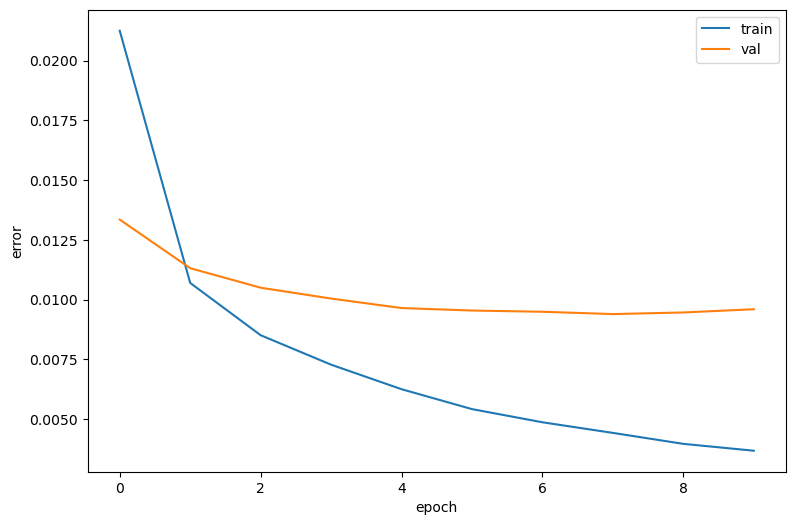

In [28]:
plt.figure(figsize=(9, 6))
plt.plot(clf.log_loss, label="train")
plt.plot(clf.log_loss_val, label="val")
plt.xlabel("epoch")
plt.ylabel("error")
plt.legend()
plt.show()

### ネットワークパターン２

In [29]:
nn = [
    FC(784, 400, XavierInitializer(), AdaGrad(0.01), Sigmoid()),
    FC(400, 200, XavierInitializer(), AdaGrad(0.01), Sigmoid()),
    FC(200, 10, SimpleInitializer(0.01), AdaGrad(0.01), Softmax()),
]

In [30]:
clf = ScratchDeepNeuralNetrowkClassifier(layers=nn, verbose=False)
clf.fit(X_train, y_train_one_hot, X_valid, y_valid_one_hot, n_epoch=10, n_batch=20, lr=0.01)

In [31]:
y_pred = clf.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred)
print('accuracy:{:.3f}'.format(accuracy))

accuracy:0.957


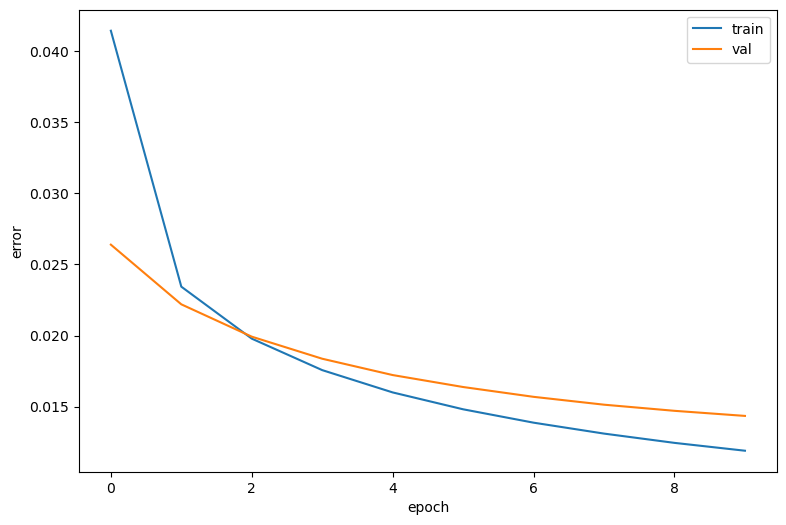

In [32]:
plt.figure(figsize=(9, 6))
plt.plot(clf.log_loss, label="train")
plt.plot(clf.log_loss_val, label="val")
plt.xlabel("epoch")
plt.ylabel("error")
plt.legend()
plt.show()

### ネットワークパターン３

In [33]:
nn = [
    FC(784, 512, HeInitializer(), AdaGrad(0.01), ReLU()),
    FC(512, 256, HeInitializer(), AdaGrad(0.01), ReLU()),
    FC(256, 128, HeInitializer(), AdaGrad(0.01), ReLU()),
    FC(128, 10, SimpleInitializer(0.01), AdaGrad(0.01), Softmax()),
]

In [34]:
clf = ScratchDeepNeuralNetrowkClassifier(layers=nn, verbose=False)
clf.fit(X_train, y_train_one_hot, X_valid, y_valid_one_hot, n_epoch=5, n_batch=20, lr=0.01)

In [35]:
y_pred = clf.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred)
print('accuracy:{:.3f}'.format(accuracy))

accuracy:0.970


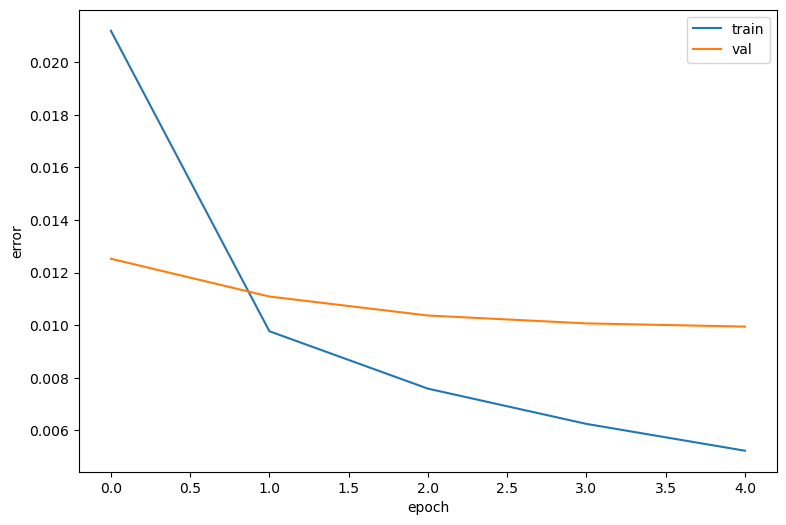

In [36]:
plt.figure(figsize=(9, 6))
plt.plot(clf.log_loss, label="train")
plt.plot(clf.log_loss_val, label="val")
plt.xlabel("epoch")
plt.ylabel("error")
plt.legend()
plt.show()